In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
from torch.optim import RMSprop, SGD
from torch.optim.lr_scheduler import ExponentialLR
from torch.nn import MSELoss
import matplotlib.pyplot as plt

from thermonet.net import ThermoNetNew
from thermonet.dataset import ThermoDatasetNew
from utils.plot import PlotHandler

In [9]:
def epoch(net, dataloader, loss_func, optimizer, scheduler):
    epoch_losses = np.zeros([len(dataloader), ])

    for i, d in enumerate(dataloader):
        inp = d[:, [0, -2, -1]]
        targets = d[:, [1, 2, 3, 4]]

        # Remove NaN values from targets (can occur because not every phase is defined in the same temperature range in the SGTE data)
        not_nas = torch.where(~torch.isnan(targets))
        targets = targets[not_nas]

        # Forward pass
        predictions = net(inp.float())
        predictions = predictions[not_nas]
        
        # Get the loss
        loss = loss_func(predictions, targets.float())
        
        # Backward pass
        net.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses[i] = loss
    scheduler.step()

    mean_epoch_loss = epoch_losses.mean(axis=0)
    #print('Mean epoch loss: ', mean_epoch_loss)
    return mean_epoch_loss

def train(net, dataloader, optimizer, scheduler, loss_func, nr_epochs=500):
    losses = []
    
    best_loss = epoch(net, dataloader, loss_func, optimizer, scheduler)
    best_net = net
    
    ph = PlotHandler()

    for i in range(nr_epochs):
        #print('-----\nEpoch %i:\n' % i)
        loss = epoch(net, dataloader, loss_func, optimizer, scheduler)
        losses.append(loss)
        
        if loss < best_loss:
            best_net = net
            
        if i % 10 == 0:
            print(i, ': ', loss)
            print('lr: ', scheduler.get_last_lr())
            last_losses = np.array(losses[-50:])
            last_losses_std, last_losses_mean = last_losses.std(), last_losses.mean()
            last_loss_diffs = np.diff(last_losses)
            print(np.mean(last_loss_diffs))
            print(last_losses_std/np.mean(last_loss_diffs), last_losses_std, last_losses_mean)
            print()
                
        if i % 250 == 0:
            ph.properties_temp_modified_new(best_net, ['Fe'], 'BCC_A2', start_temp=200, end_temp=2000)
            plt.plot(losses)
            
    return losses, net

In [10]:
# Hyperparameters
nr_epochs = 2500
lr = 0.005 # 0.000025
batch_size = 1024
hidden_size = 128
hidden_layers = 8

In [11]:
# Network
net = ThermoNetNew(hidden_size_linear=hidden_size, hidden_layers=hidden_layers) 

# Optimizer
optimizer = RMSprop(net.parameters(), lr=lr)
scheduler = ExponentialLR(optimizer, gamma=0.995)

# Loss function
loss_func = MSELoss()

In [12]:
# Dataset
start_temp, end_temp = 200, 2000
step = 1
dataset = ThermoDatasetNew(['Fe'], start_temp=start_temp, end_temp=end_temp, step=step)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

0 :  1087.1859910753037
lr:  [0.0049501250000000005]
nan
nan 0.0 1087.1859910753037



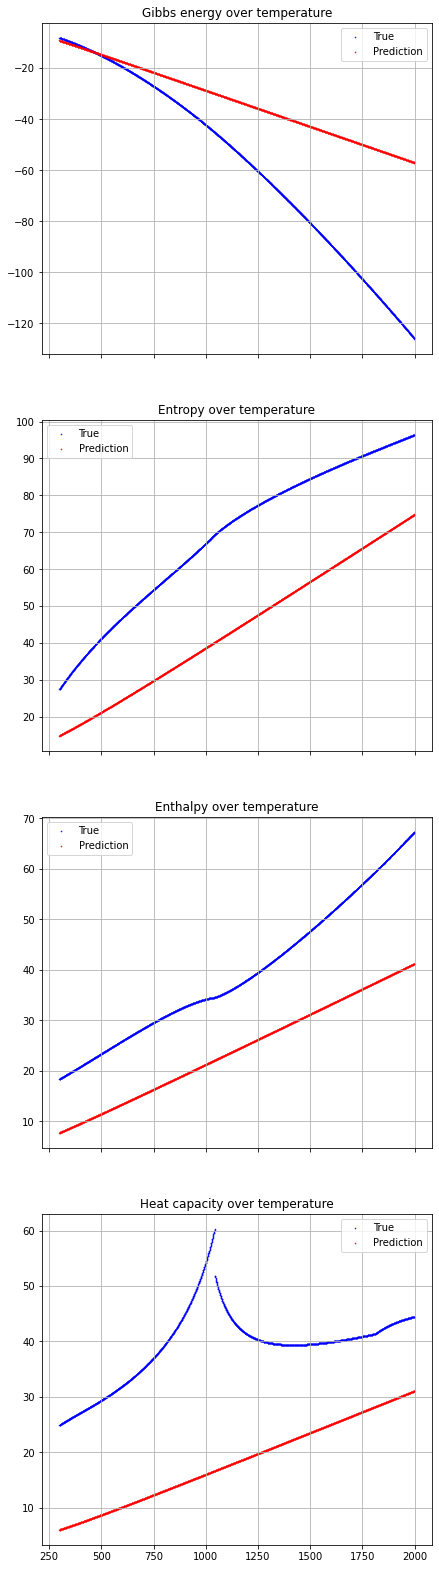

10 :  119.19605170355902
lr:  [0.0047081140345718794]
-96.79899393717452
-33.78080089604691 3269.9475411293442 1368.3354049836746

20 :  119.57812754313152
lr:  [0.004477934953669392]
-48.38039317660851
-50.58599293614865 2447.370227480012 773.8923208246784

30 :  114.86725362141927
lr:  [0.004259009298001735]
-32.41062458179611
-62.858835559651425 2037.2941209727178 563.4108108465816

40 :  110.21839480929904
lr:  [0.0040507868890773645]
-24.424189906650124
-72.95473820686279 1781.86038055436 454.48218991246006

50 :  199.74415334065756
lr:  [0.0038527444465594088]
-11.819062230808653
-136.70093553658245 1615.67686411663 377.6764973958333

60 :  116.89705657958984
lr:  [0.003664384273218397]
-0.08587935397954732
-279.0562444955668 23.965170001237883 126.6516138543023

70 :  112.67177327473958
lr:  [0.003485233004177472]
-0.043054835866629206
-12213.826484433133 525.8642945907574 201.47001346164282

80 :  97.27863396538629
lr:  [0.0033148404173068496]
-0.3384468441917795
-1555.05990900

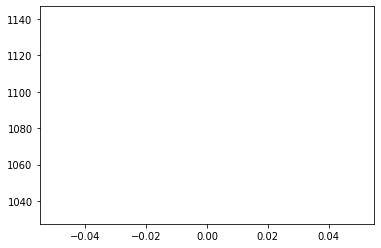

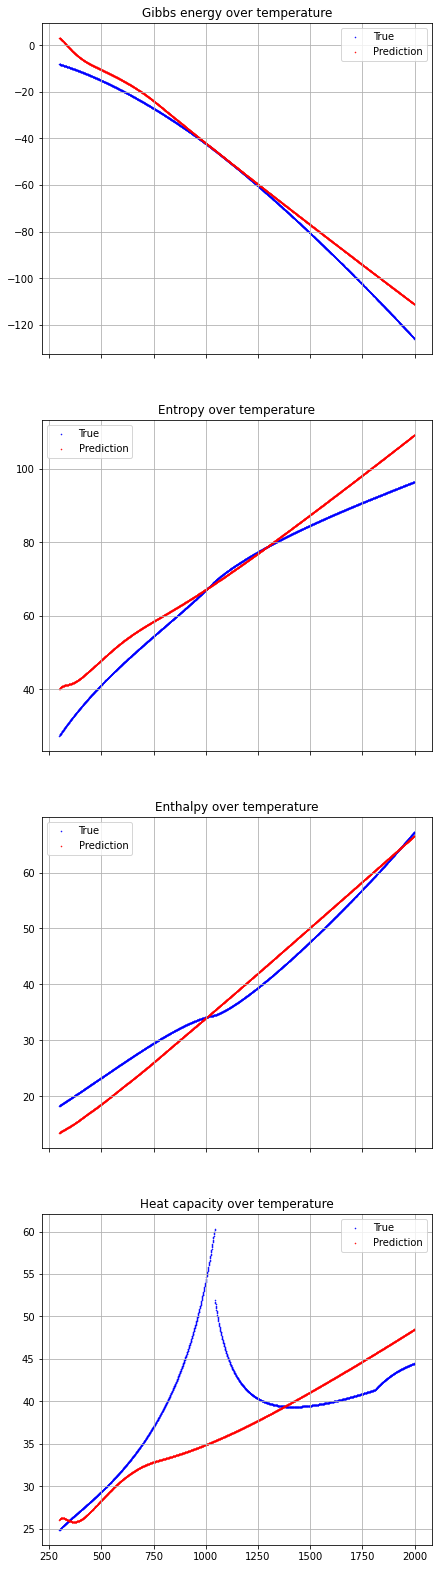

260 :  30.470790439181858
lr:  [0.001344674470867846]
-0.8687017704624165
-22.957825244084933 19.94350343550334 48.91096458011202

270 :  28.01388168334961
lr:  [0.0012789335114211096]
-0.6887041295196464
-14.191171465553099 9.773518391047793 40.00776407877604

280 :  27.436061011420357
lr:  [0.001216406618904779]
-0.4911348425071526
-13.473072196267777 6.6170951912014715 34.8478533299764

290 :  24.189429812961155
lr:  [0.0011569366580059526]
-0.35823188833638925
-13.813519560518381 4.948443196736149 31.30786226908366

300 :  24.44517029656304
lr:  [0.0011003741757366753]
-0.21094044103644063
-20.01992258809361 4.223011300247866 29.117967851426865

310 :  24.707716200086807
lr:  [0.0010465770258460752]
-0.1017222069288327
-43.76888610136521 4.452267689047582 27.836478627522794

320 :  21.746562745836044
lr:  [0.00099541001159494]
-0.1497948618432562
-31.0801952437639 4.655653552601041 26.778323660956488

330 :  21.536892149183487
lr:  [0.0009467445459949988]
-0.10652772639614114
-39.0

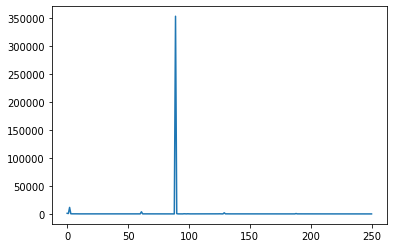

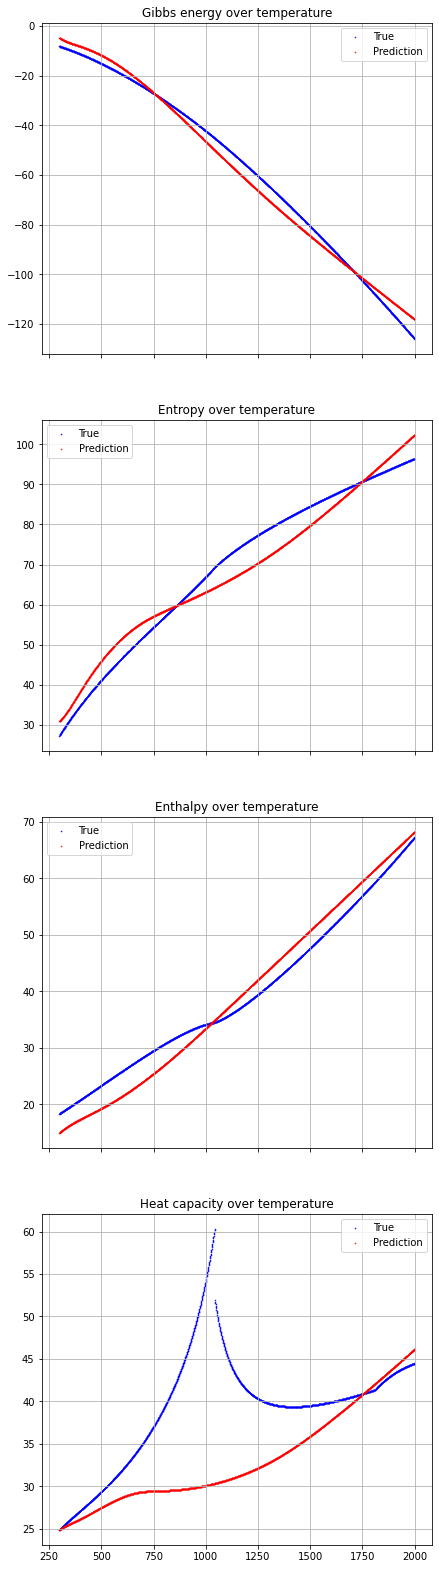

510 :  27.24840694003635
lr:  [0.00038404962567312596]
0.07285759940979962
352.1542340596892 25.65711211558565 30.435916328430174

520 :  33.00670305887858
lr:  [0.0003652734895792976]
0.1917685381138944
133.3118957140798 25.565027354281032 30.94522370232476

530 :  23.326289706759983
lr:  [0.00034741531632945347]
-0.020633576408265675
-1239.7051690656513 25.579551329638033 30.882201402452253

540 :  21.33294465806749
lr:  [0.0003304302268399139]
0.0030012887621672477
8538.458638113847 25.62637995680095 30.682925923665366

550 :  21.3612732357449
lr:  [0.00031427553615954513]
-0.16846084594726562
-21.564857789472814 3.632834185947071 25.493695890638563

560 :  21.831011454264324
lr:  [0.00029891064619890525]
-0.09343640333941192
-41.237056960204924 3.853042286664011 24.68143026987712

570 :  26.01112280951606
lr:  [0.000284296943703849]
0.07333492529905841
51.79676048259656 3.7985115607244397 24.051509251064722

580 :  26.20540894402398
lr:  [0.000270397703217188]
0.013166306510804159


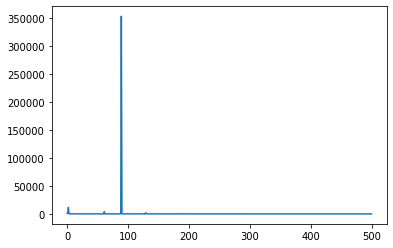

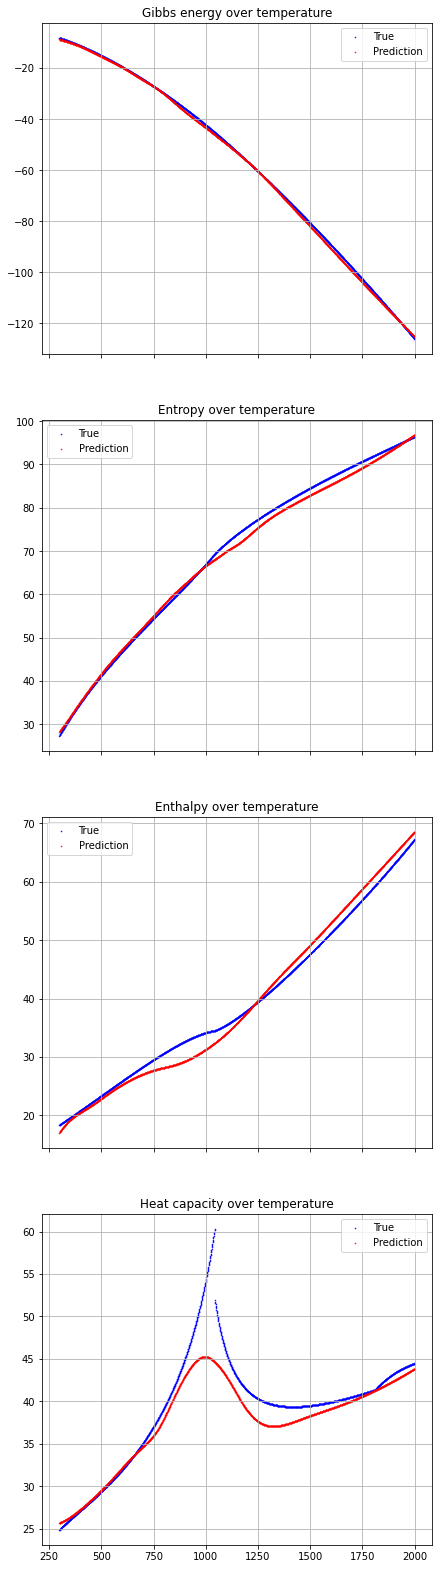

760 :  10.979741467369927
lr:  [0.00010968759961991128]
-0.04138147155173514
-44.37298864845456 1.8362195674214885 11.374125034544202

770 :  9.134431786007351
lr:  [0.00010432498718497115]
-0.07112474398277785
-24.329863714659073 1.730455327841003 10.712987075381808

780 :  9.419878005981445
lr:  [9.922455217233788e-05]
-0.002792888217502166
-555.1323423522863 1.5504225781100789 10.052075440088908

790 :  7.940833409627278
lr:  [9.437347676204006e-05]
-0.030408245095320002
-51.28822297420187 1.5595848547029527 9.482177582846749

800 :  6.136090596516927
lr:  [8.975956979565241e-05]
-0.09983877367984136
-15.913282151743749 1.588762575251403 8.9171293258667

810 :  4.816716194152832
lr:  [8.537123613889452e-05]
-0.11738976113109631
-12.843690175613833 1.5077177217571163 8.312929304970634

820 :  3.56068754196167
lr:  [8.11974475420882e-05]
-0.07684765705445996
-20.98860988089248 1.612925494176675 7.7650764634874125

830 :  7.28488466474745
lr:  [7.722771492524318e-05]
-0.023315491319513

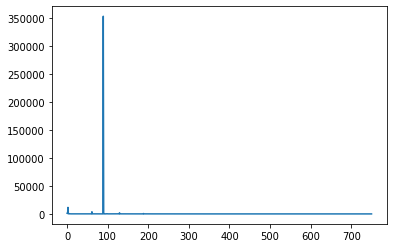

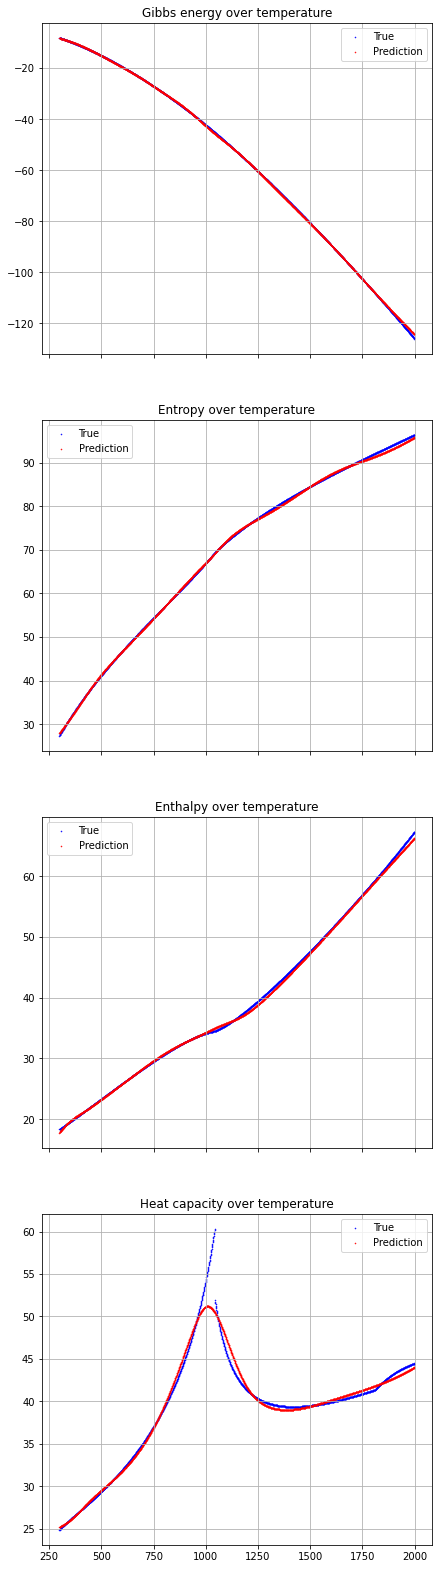

1010 :  0.2944855723116133
lr:  [3.132764285159898e-05]
-0.0003711310914314391
-5605.1974183347165 2.080263035555248 0.9700252922375998

1020 :  0.17984112434917027
lr:  [2.9796038479769403e-05]
-0.0015021927164795658
-1783.3841670185323 2.6789867063802166 1.2997810937298666

1030 :  0.32958900928497314
lr:  [2.8339314045856632e-05]
0.0019648262635379547
1291.52095412409 2.53761429057261 1.1099763805005285

1040 :  0.1416926226682133
lr:  [2.695380867946518e-05]
-0.007392473958111715
-414.6102255972353 3.064995295494385 1.2031586439576414

1050 :  0.26322880221737754
lr:  [2.563604048967558e-05]
0.0015843746478325406
1767.5094379052 2.800397143221743 0.9412227671345075

1060 :  0.12092085265451008
lr:  [2.438269781476115e-05]
-0.006159762220452996
-475.9088183035597 2.9314851593666966 1.059813418885072

1070 :  0.22019570734765795
lr:  [2.319063089970496e-05]
0.001236147958945782
1917.9647038091996 2.3708881539437936 0.6819915448460313

1080 :  0.10472624252239864
lr:  [2.2056843980601

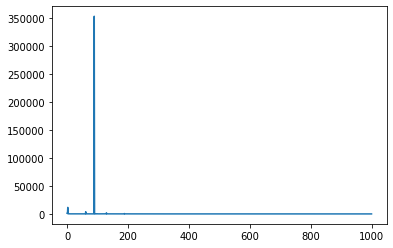

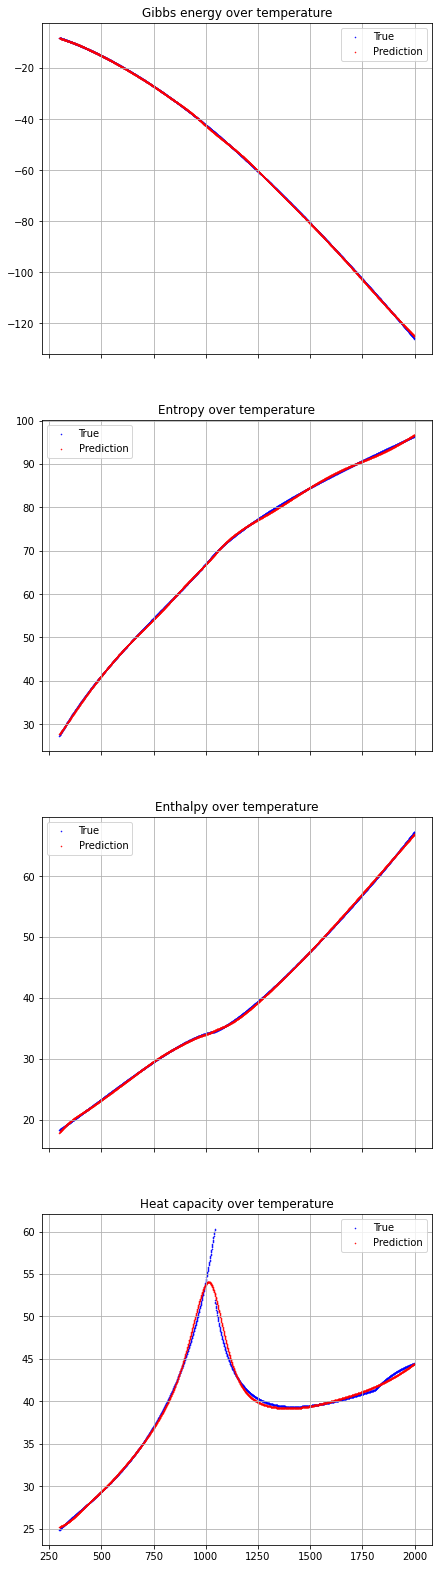

1260 :  0.07360586441225475
lr:  [8.947421677912122e-06]
-0.00014296520391559177
-1779.460259495419 0.2544008988584544 0.10606353977074225

1270 :  0.05745743422044648
lr:  [8.509983399411275e-06]
-0.0003389223751162157
-751.4319519964336 0.25467710190884546 0.10400466346906292

1280 :  0.07745842594239447
lr:  [8.09393142127561e-06]
3.082674343029475e-05
8273.74479403264 0.2550526079733811 0.0998384713836842

1290 :  0.050913129415777
lr:  [7.698220170070455e-06]
-0.00018205752178114345
-633.8602947172719 0.11539903441169175 0.08019272070791987

1300 :  0.060252781957387924
lr:  [7.3218551903099484e-06]
3.2521133858060896e-05
3556.4417975333386 0.11565951975598442 0.07897427732331885

1310 :  0.05286687157220311
lr:  [6.963890645307184e-06]
-0.0004954845507263847
-233.93777590082357 0.11591255379014923 0.07700840919382043

1320 :  0.05714633771114879
lr:  [6.6234269402074865e-06]
6.24041032899278e-05
1858.9702283179577 0.11600737014085451 0.07512816048744651

1330 :  0.053636406444840

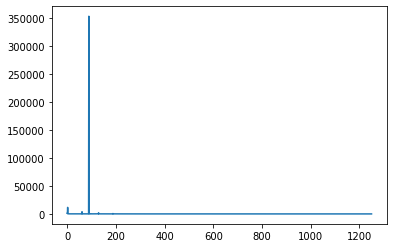

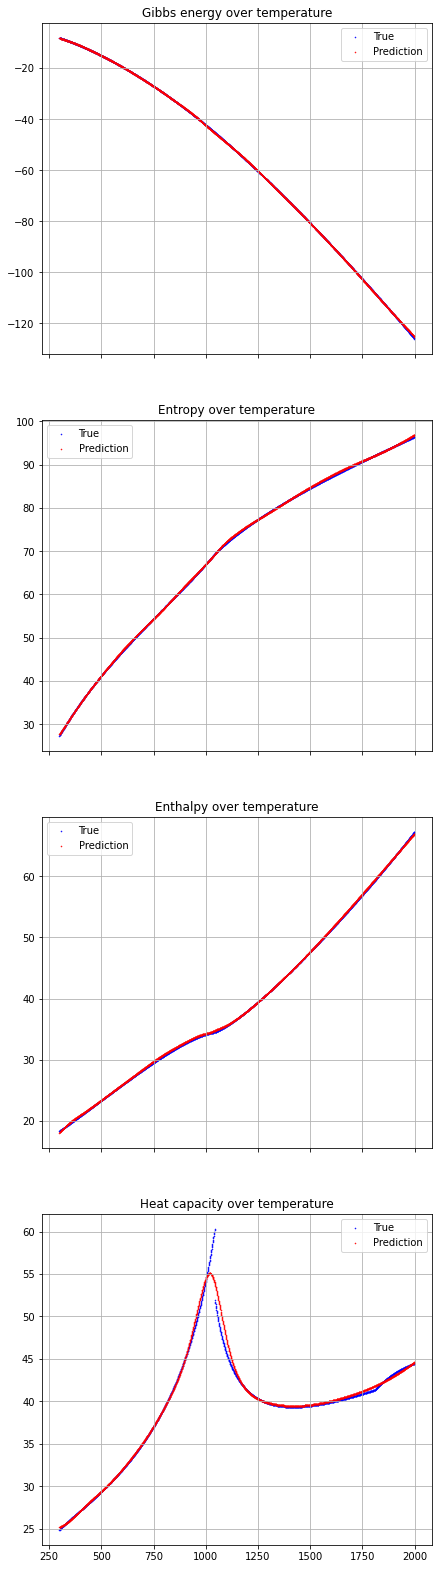

1510 :  0.04163643345236778
lr:  [2.5554541419411577e-06]
-0.00010201041829558995
-23.451781776444683 0.0023923260687920157 0.0442789083139764

1520 :  0.04086991730663511
lr:  [2.430518322340951e-06]
-4.3938916320162914e-05
-53.808028847220044 0.0023642664768709137 0.043948121679325894

1530 :  0.03946820812092887
lr:  [2.3116905986611514e-06]
-0.00011941479717522799
-20.248597350788664 0.002417982145727287 0.04347792060838805

1540 :  0.04130514069563813
lr:  [2.1986723468891056e-06]
-0.0001409191621336537
-15.657410244840179 0.002206429132885764 0.042894294282628434

1550 :  0.03985056198305554
lr:  [2.0911795427011816e-06]
-9.232142395308233e-05
-24.635874451225703 0.0022744190096665178 0.04224553406652477

1560 :  0.03945813017586867
lr:  [1.9889420476858746e-06]
-3.8641756252637015e-05
-54.34167472932661 0.0020998577492507236 0.04172564030521445

1570 :  0.03910605340368218
lr:  [1.8917029304633716e-06]
-0.00014887710868501344
-11.7699367402607 0.001752274151295525 0.041163174878

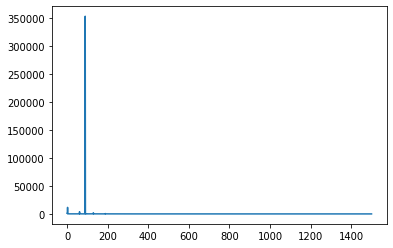

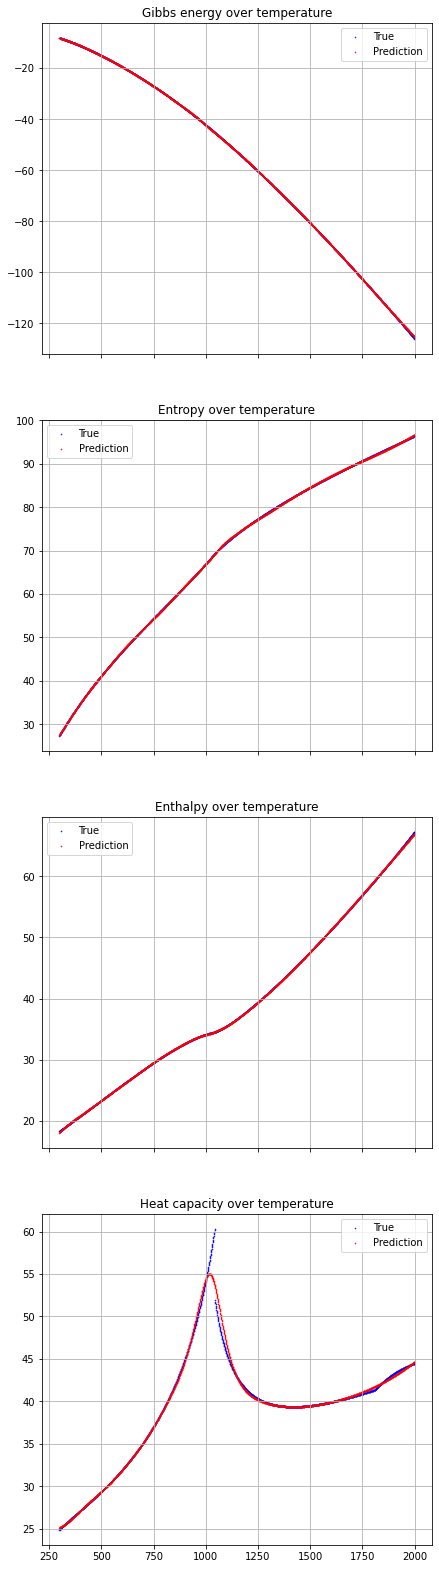

1760 :  0.03760120624469386
lr:  [7.298578413583913e-07]
-4.334607564943479e-06
-256.4576941161374 0.0011116434610037701 0.036858568359166385

1770 :  0.03907321207225323
lr:  [6.941751867158463e-07]
2.5205238133060688e-05
45.25352617011718 0.0011406259034784975 0.036933800054507124

1780 :  0.035958574877844915
lr:  [6.602370524034101e-07]
-5.5662417560477944e-05
-22.582133121325853 0.0012569761232055388 0.036989634378502764

1790 :  0.036309864165054426
lr:  [6.279581490497442e-07]
-8.897906562098124e-06
-135.85624698225106 0.0012088361915253952 0.036779226232320064

1800 :  0.035410176755653486
lr:  [5.972573570697468e-07]
-3.843823798389454e-06
-338.7008128452627 0.0013019062449484734 0.036670119050476284

1810 :  0.03510196879506111
lr:  [5.680575228042489e-07]
-1.3772571404504684e-05
-104.93376381964015 0.0014452077549494242 0.03664105067236556

1820 :  0.036967792444758944
lr:  [5.402852646264125e-07]
3.3408530107160766e-05
42.45048132442701 0.0014182081833905857 0.0365276166713

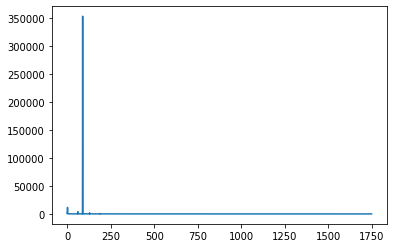

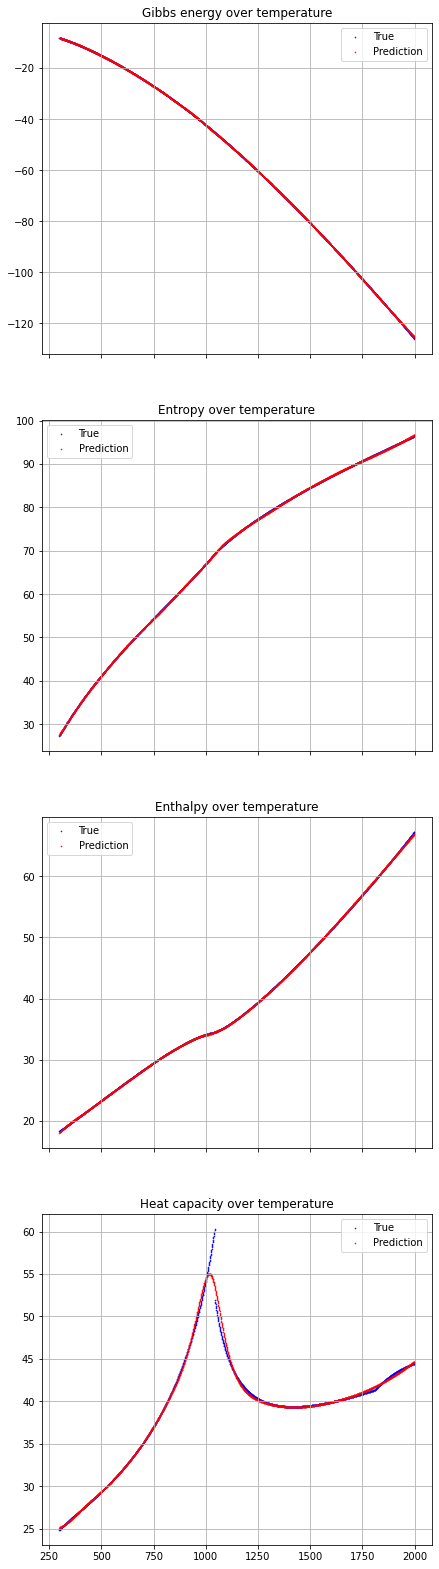

2010 :  0.034451757040288716
lr:  [2.0845315118340978e-07]
-4.503250865437639e-07
-3630.811258710817 0.0016350453943030211 0.03491512427520421

2020 :  0.035644401899642415
lr:  [1.9826190381805415e-07]
-4.646013535204392e-05
-35.98440888164014 0.0016718405072042926 0.035023543327632876

2030 :  0.03330636355612013
lr:  [1.8856890520678178e-07]
-9.887393504854358e-06
-172.23547169642347 0.0017029598841567441 0.03493602261154188

2040 :  0.03367367862827248
lr:  [1.7934979603301001e-07]
-5.4305938839101516e-05
-28.53762100763351 0.001549762301054004 0.03465824456885457

2050 :  0.03445611542297734
lr:  [1.7058140790396574e-07]
8.068484615306465e-06
194.26326497493758 0.001567410164769487 0.03460668935543962

2060 :  0.033951025249229536
lr:  [1.6224170512657589e-07]
-0.00011142336524803358
-12.753852561618563 0.001421077172292794 0.03450301250856784

2070 :  0.03661830578413275
lr:  [1.5430972932992683e-07]
7.054947586962428e-05
19.164719222698594 0.001352060896349899 0.0343603215573562

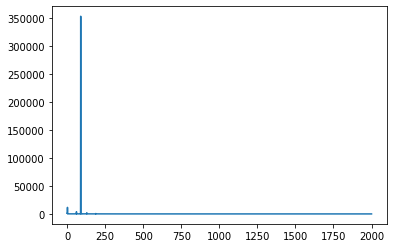

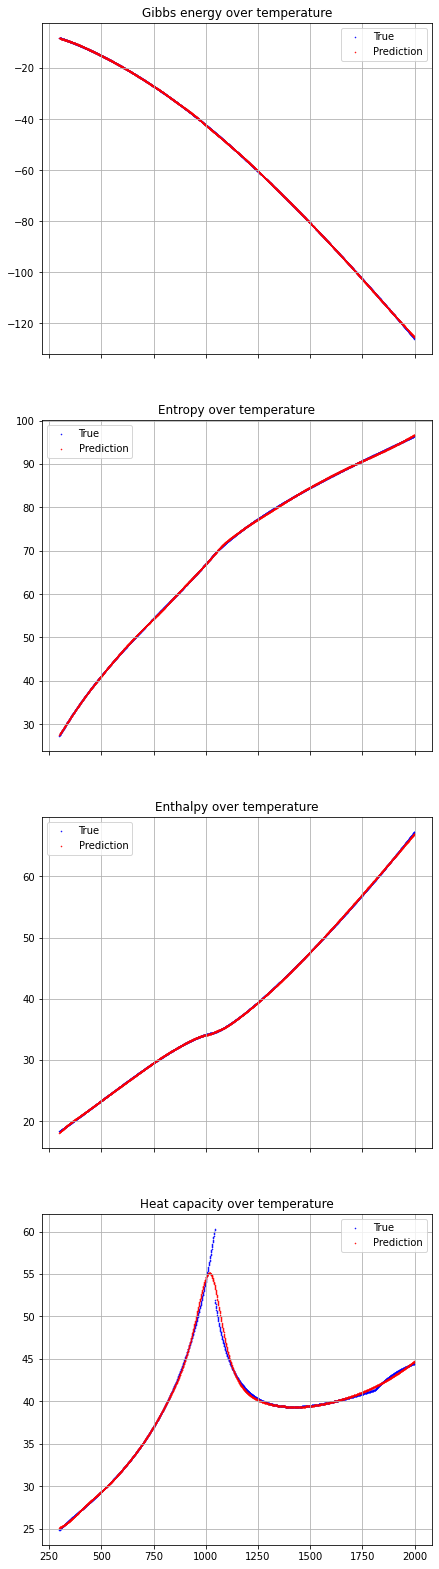

2260 :  0.03447117946214146
lr:  [5.9535862706387415e-08]
9.395498909106823e-06
143.90019668321952 0.0013520141409574464 0.03394539118847914

2270 :  0.03292264830734995
lr:  [5.662516214606441e-08]
-7.325732687703512e-06
-198.7239560364543 0.001455798580566009 0.03406272797534863

2280 :  0.035875834731592074
lr:  [5.3856765356388806e-08]
5.536346512586897e-05
26.93893007326192 0.0014914325156392592 0.03410385960506069

2290 :  0.03425675878922144
lr:  [5.122371512457942e-08]
-2.8383633007808608e-05
-46.451210861544254 0.0013184541218624053 0.03408016531624728

2300 :  0.033968064934015274
lr:  [4.871939437508027e-08]
1.6939169526640852e-05
85.38970382678448 0.0014464306689515555 0.03419233122012681

2310 :  0.03315624718864759
lr:  [4.633750954029599e-08]
8.954943206304944e-06
157.27231138887223 0.001408364616411657 0.034078741876615415

2320 :  0.03527825532688035
lr:  [4.407207474432987e-08]
4.40662224141379e-05
27.566552325320806 0.001214753825958557 0.03397016464008226

2330 :  0

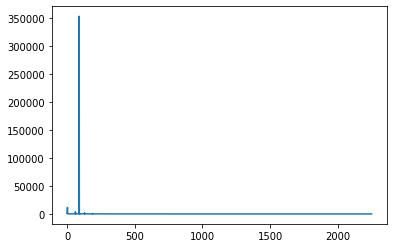

In [13]:
losses, best_net = train(net, dataloader, optimizer=optimizer, scheduler=scheduler, loss_func=loss_func, nr_epochs=nr_epochs)

In [ ]:
plt.plot(losses[1400:])

In [14]:
#torch.save(net, 'Fe_2.pth')

In [5]:
net = torch.load(r"C:\Users\danie\Documents\Montanuni\Masterarbeit\5 Programmcodes\packages\thermonet\thermonet\models\Fe_C.pth")

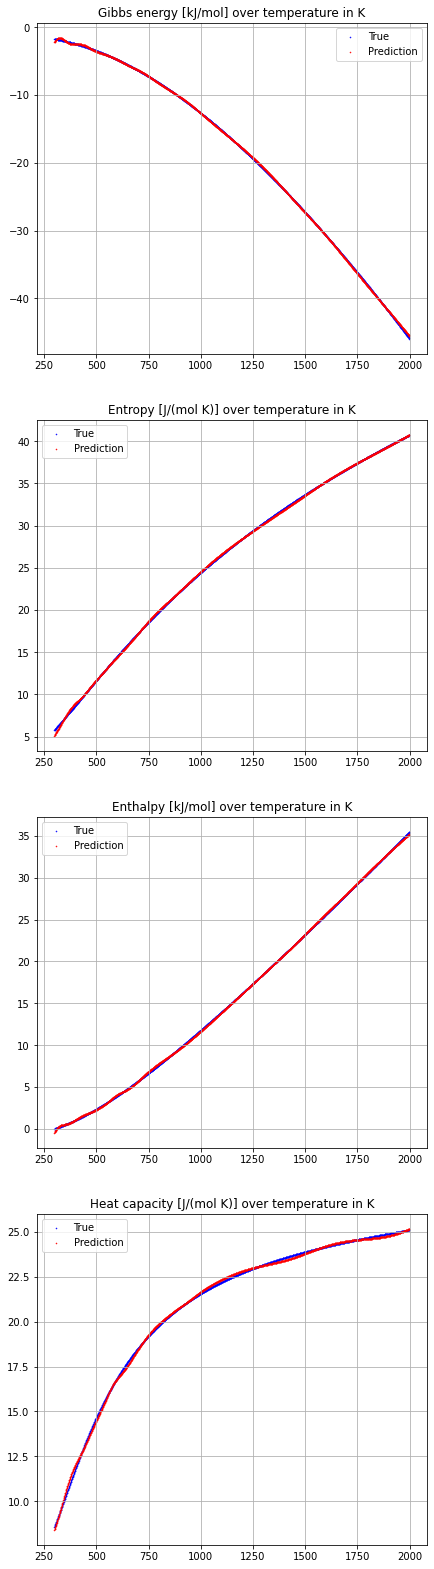

In [11]:
ph = PlotHandler()

ph.properties_temp_modified_new(net, ['C'], 'GRAPHITE', start_temp=200, end_temp=2000)